In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install scikit-optimize bayesian-optimization

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 2.7 MB/s eta 0:00:00


In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score, root_mean_squared_log_error,mean_absolute_percentage_error,mean_squared_error
from skopt import BayesSearchCV
from xgboost import XGBRegressor
from sklearn.linear_model import Lasso, Ridge
from sklearn.model_selection import GridSearchCV
from bayes_opt import BayesianOptimization

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [5]:
sqrt_data=pd.read_csv("/content/drive/MyDrive/GUVI Capstone projects/Project3/debugging seperately/sqrt_transformed.csv")
log_data=pd.read_csv("/content/drive/MyDrive/GUVI Capstone projects/Project3/debugging seperately/log_transformed.csv")
box_data=pd.read_csv("/content/drive/MyDrive/GUVI Capstone projects/Project3/debugging seperately/boxcox_transformed.csv")

In [11]:
box_data.head()

,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount
0,0,0,42.547025,1,0,1,1,1,2,2,1,2,1,1,0,0,1,2,60.338075
1,1,0,59.779831,0,2,2,0,1,0,1,0,2,2,0,1,1,2,2,45.544911
2,0,1,56.157517,0,2,0,1,3,1,2,0,2,1,0,2,1,1,2,29.997609
3,0,1,91.687601,1,1,1,0,0,0,0,0,0,1,0,0,1,3,0,34.206118
4,0,1,63.836395,2,0,1,1,1,0,2,0,1,1,1,0,1,1,2,52.001891


In [6]:
# Function to evaluate models
def evaluate_model(model, X_train, y_train, X_test, y_test,transformation):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Reverse transformation based on the specified type
    if transformation == 'log':
        y_pred_exp = np.expm1(y_pred)
        y_test_exp = np.expm1(y_test)
    elif transformation == 'sqrt':
        y_pred_exp = y_pred ** 2
        y_test_exp = y_test ** 2
    else:
        y_pred_exp = (y_pred * 0.4070919527624085) ** (1 / 0.4070919527624085)
        y_test_exp = (y_test * 0.4070919527624085) ** (1 / 0.4070919527624085)

    rmse = np.sqrt(mean_squared_error(y_test_exp, y_pred_exp))
    mae = mean_absolute_error(y_test_exp, y_pred_exp)
    r2 = r2_score(y_test_exp, y_pred_exp)
    rmsle=root_mean_squared_log_error(y_test_exp, y_pred_exp)

    print(f"✅ Model: {type(model).__name__}")
    print(f"🔹 RMSE: {rmse:.4f}")
    print(f"🔹 MAE: {mae:.4f}")
    print(f"🔹 R² Score: {r2:.4f}")
    print(f"🔹 RMSLE: {rmsle:.4f}")


## Linear Regression

## Model analysis using box data

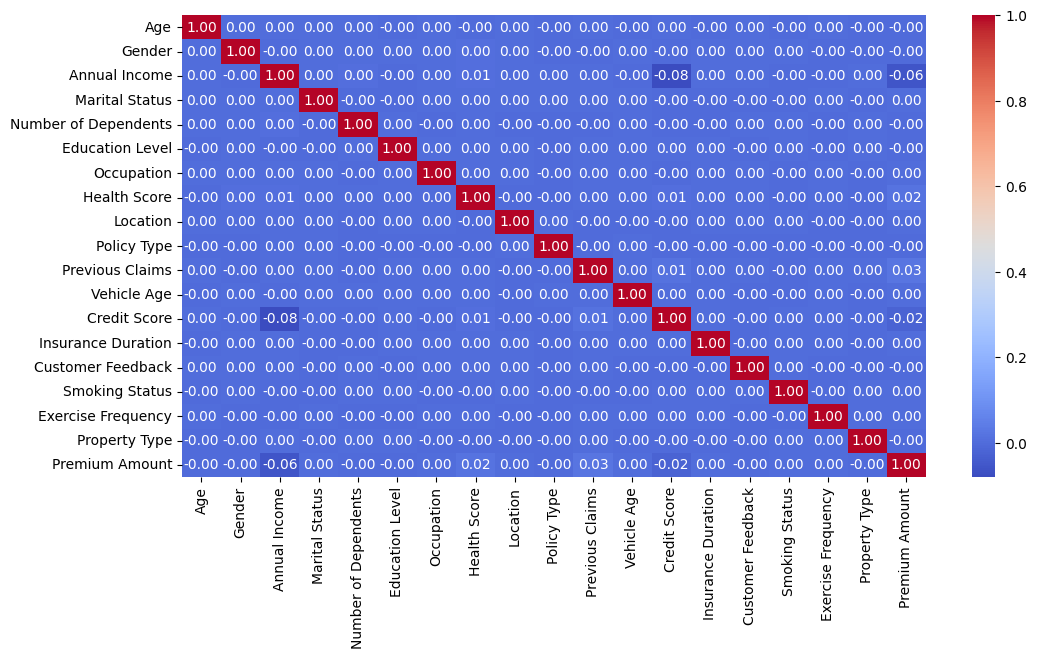

In [ ]:
plt.figure(figsize=(12,6))
sns.heatmap(box_data.corr(), cmap="coolwarm", fmt = '.2f', annot= True)
plt.show()

In [ ]:
# Step 1: Define Features & Target
X = box_data.drop(columns=["Premium Amount"])
y = box_data["Premium Amount"]

# Step 2: Split into Train & Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Initialize scaler
scaler = StandardScaler()

# Apply only to Annual Income
X_train["Annual Income"] = scaler.fit_transform(X_train[["Annual Income"]])
X_test["Annual Income"] = scaler.transform(X_test[["Annual Income"]])

Linear Regression Analysis

In [ ]:
model = LinearRegression()

In [ ]:
evaluate_model(model, X_train, y_train, X_test, y_test,"boxcox")


✅ Model: LinearRegression
🔹 RMSE: 804.4031
🔹 MAE: 580.6750
🔹 R² Score: -0.0627
🔹 RMSLE: 1.2365


Ridge and lasso

In [ ]:
lasso = Lasso(alpha= 0.1)

In [ ]:
evaluate_model(lasso, X_train, y_train, X_test, y_test,"boxcox")

✅ Model: Lasso
🔹 RMSE: 804.3957
🔹 MAE: 580.7560
🔹 R² Score: -0.0627
🔹 RMSLE: 1.2370


In [ ]:
ridge = Ridge(alpha= 1)

In [ ]:
evaluate_model(ridge, X_train, y_train, X_test, y_test,"boxcox")

✅ Model: Ridge
🔹 RMSE: 804.4031
🔹 MAE: 580.6750
🔹 R² Score: -0.0627
🔹 RMSLE: 1.2365


Tuning of Ridge

In [ ]:
# Define parameter grid

param_grid = {"alpha": [0.01, 0.1, 1, 10, 100]}

# Grid Search for Ridge Regression
ridge = GridSearchCV(Ridge(), param_grid, cv=5, scoring="neg_mean_squared_error")
ridge.fit(X_train, y_train)

print(f"Best Ridge Alpha: {ridge.best_params_['alpha']}")
evaluate_model(ridge.best_estimator_, X_train, y_train, X_test, y_test,"boxcox")

Best Ridge Alpha: 100
✅ Model: Ridge
🔹 RMSE: 804.4030
🔹 MAE: 580.6750
🔹 R² Score: -0.0627
🔹 RMSLE: 1.2365


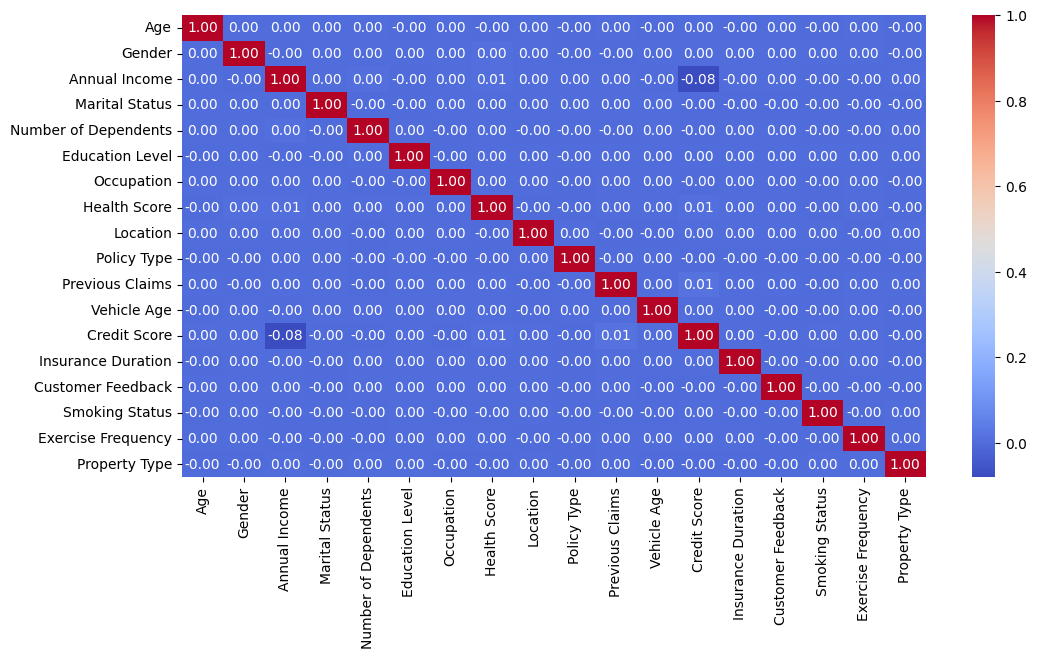

In [ ]:
plt.figure(figsize=(12,6))
sns.heatmap(X_train.corr(), cmap="coolwarm", fmt = '.2f', annot= True)
plt.show()

## Using Log transformed data

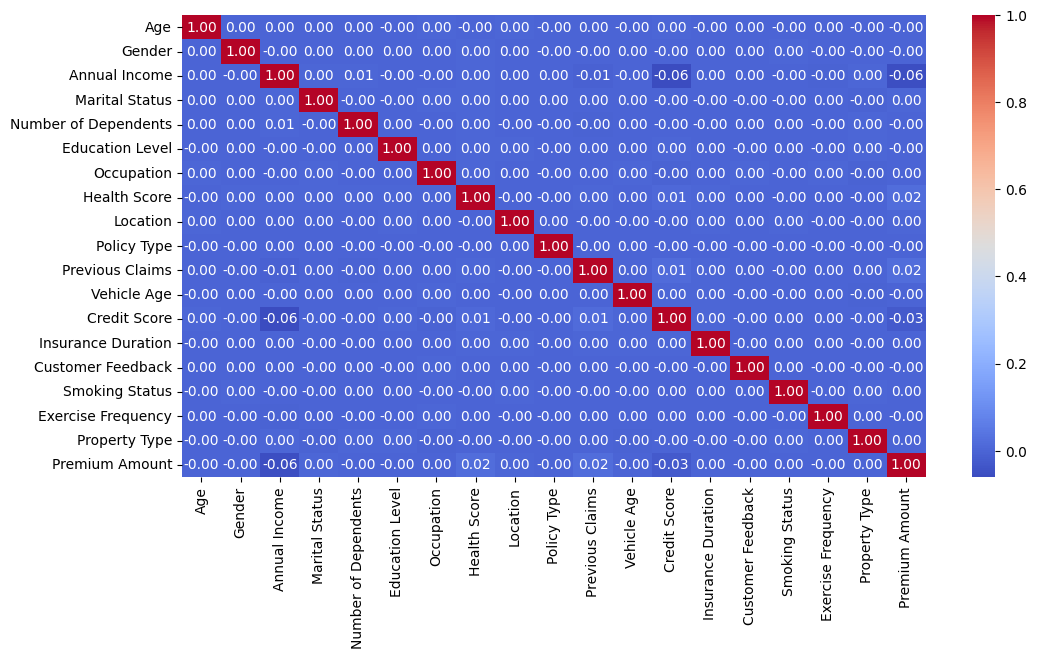

In [ ]:
plt.figure(figsize=(12,6))
sns.heatmap(log_data.corr(), cmap="coolwarm", fmt = '.2f', annot= True)
plt.show()

In [ ]:
# Step 1: Define Features & Target
X = log_data.drop(columns=["Premium Amount"])
y = log_data["Premium Amount"]

# Step 2: Split into Train & Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Initialize scaler
scaler = StandardScaler()

# Apply only to Annual Income
X_train["Annual Income"] = scaler.fit_transform(X_train[["Annual Income"]])
X_test["Annual Income"] = scaler.transform(X_test[["Annual Income"]])

Linear Regression Analysis

In [ ]:
model = LinearRegression()

In [ ]:
evaluate_model(model, X_train, y_train, X_test, y_test,"log")


✅ Model: LinearRegression
🔹 RMSE: 924.1714
🔹 MAE: 647.3299
🔹 R² Score: -0.1854
🔹 RMSLE: 1.0895


Ridge and lasso

In [ ]:
lasso = Lasso(alpha= 0.1)

In [ ]:
evaluate_model(lasso, X_train, y_train, X_test, y_test,"log")

✅ Model: Lasso
🔹 RMSE: 925.5360
🔹 MAE: 649.2797
🔹 R² Score: -0.1890
🔹 RMSLE: 1.0921


In [ ]:
ridge = Ridge(alpha= 1)

In [ ]:
evaluate_model(ridge, X_train, y_train, X_test, y_test,"log")

✅ Model: Ridge
🔹 RMSE: 924.1714
🔹 MAE: 647.3299
🔹 R² Score: -0.1854
🔹 RMSLE: 1.0895


Tuning of Ridge

In [ ]:
# Define parameter grid

param_grid = {"alpha": [0.01, 0.1, 1, 10, 100]}

# Grid Search for Ridge Regression
ridge = GridSearchCV(Ridge(), param_grid, cv=5, scoring="neg_mean_squared_error")
ridge.fit(X_train, y_train)

print(f"Best Ridge Alpha: {ridge.best_params_['alpha']}")
evaluate_model(ridge.best_estimator_, X_train, y_train, X_test, y_test,"log")

Best Ridge Alpha: 100
✅ Model: Ridge
🔹 RMSE: 924.1715
🔹 MAE: 647.3299
🔹 R² Score: -0.1854
🔹 RMSLE: 1.0895


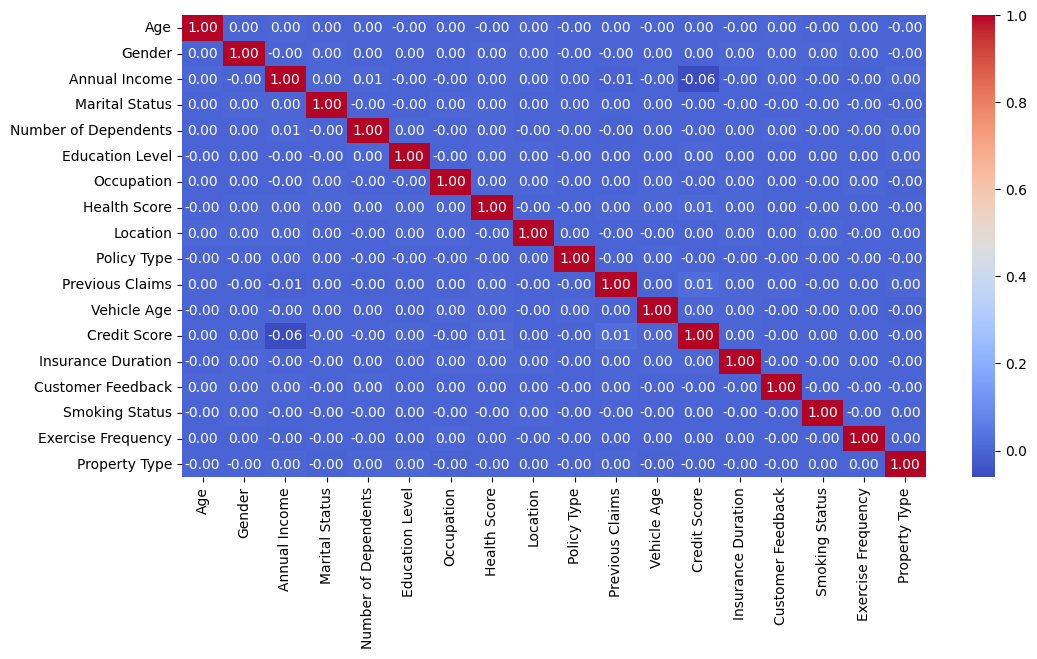

In [ ]:
plt.figure(figsize=(12,6))
sns.heatmap(X_train.corr(), cmap="coolwarm", fmt = '.2f', annot= True)
plt.show()

## Using SQRT transformed data

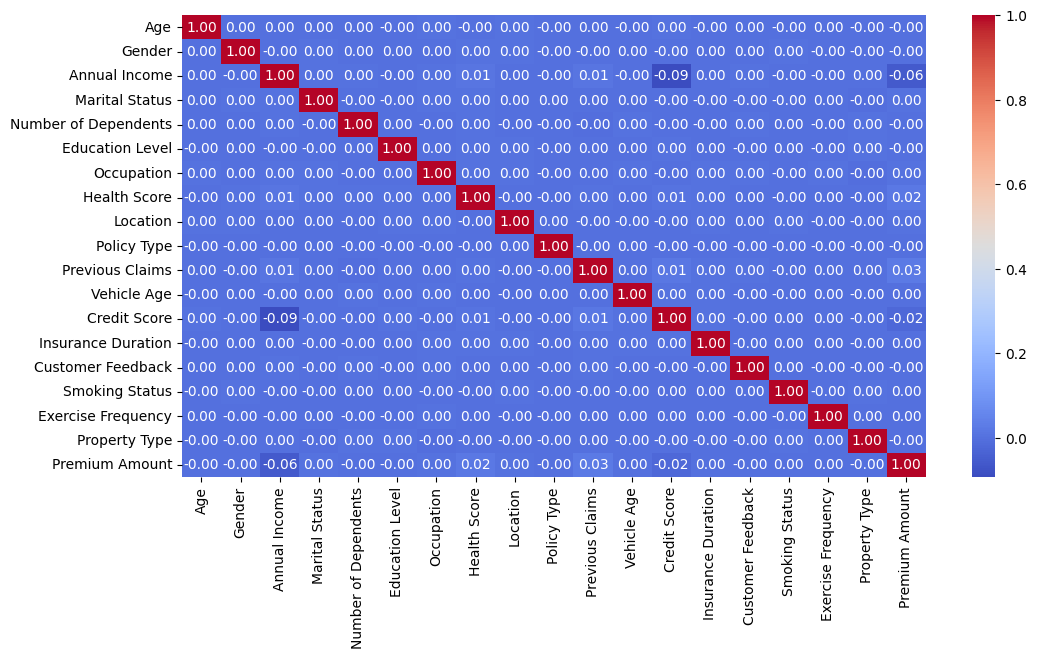

In [ ]:
plt.figure(figsize=(12,6))
sns.heatmap(sqrt_data.corr(), cmap="coolwarm", fmt = '.2f', annot= True)
plt.show()

In [ ]:
# Step 1: Define Features & Target
X = sqrt_data.drop(columns=["Premium Amount"])
y = sqrt_data["Premium Amount"]

# Step 2: Split into Train & Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Initialize scaler
scaler = StandardScaler()

# Apply only to Annual Income
X_train["Annual Income"] = scaler.fit_transform(X_train[["Annual Income"]])
X_test["Annual Income"] = scaler.transform(X_test[["Annual Income"]])

Linear Regression Analysis

In [ ]:
model = LinearRegression()

In [ ]:
evaluate_model(model, X_train, y_train, X_test, y_test,"sqrt")


✅ Model: LinearRegression
🔹 RMSE: 865.0375
🔹 MAE: 637.4741
🔹 R² Score: -0.0386
🔹 RMSLE: 1.1145


Ridge and lasso

In [ ]:
lasso = Lasso(alpha= 0.1)

In [ ]:
evaluate_model(lasso, X_train, y_train, X_test, y_test,"sqrt")

✅ Model: Lasso
🔹 RMSE: 865.0050
🔹 MAE: 637.6085
🔹 R² Score: -0.0385
🔹 RMSLE: 1.1151


In [ ]:
ridge = Ridge(alpha= 1)

In [ ]:
evaluate_model(ridge, X_train, y_train, X_test, y_test,"sqrt")

✅ Model: Ridge
🔹 RMSE: 865.0375
🔹 MAE: 637.4741
🔹 R² Score: -0.0386
🔹 RMSLE: 1.1145


Tuning of Ridge

In [ ]:
# Define parameter grid

param_grid = {"alpha": [0.01, 0.1, 1, 10, 100]}

# Grid Search for Ridge Regression
ridge = GridSearchCV(Ridge(), param_grid, cv=5, scoring="neg_mean_squared_error")
ridge.fit(X_train, y_train)

print(f"Best Ridge Alpha: {ridge.best_params_['alpha']}")
evaluate_model(ridge.best_estimator_, X_train, y_train, X_test, y_test,"sqrt")

Best Ridge Alpha: 100
✅ Model: Ridge
🔹 RMSE: 865.0374
🔹 MAE: 637.4741
🔹 R² Score: -0.0386
🔹 RMSLE: 1.1145


## Decision Tree

## Model analysis using box data

In [ ]:
# Step 1: Define Features & Target
X = box_data.drop(columns=["Premium Amount"])
y = box_data["Premium Amount"]

# Step 2: Split into Train & Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Initialize scaler
scaler = StandardScaler()

# Apply only to Annual Income
X_train["Annual Income"] = scaler.fit_transform(X_train[["Annual Income"]])
X_test["Annual Income"] = scaler.transform(X_test[["Annual Income"]])

Decision tree Analysis

In [ ]:
model = DecisionTreeRegressor(max_depth= 9, random_state= 99, min_samples_leaf=6)

In [ ]:
evaluate_model(model, X_train, y_train, X_test, y_test,"boxcox")

✅ Model: DecisionTreeRegressor
🔹 RMSE: 801.4831
🔹 MAE: 573.4034
🔹 R² Score: -0.0550
🔹 RMSLE: 1.2216


In [ ]:
# Define function for Bayesian Optimization
def tune_decision_tree(max_depth, min_samples_split):
    model = DecisionTreeRegressor(
        max_depth=int(max_depth),
        min_samples_split=int(min_samples_split),
        random_state=42
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return -np.sqrt(mean_squared_error((y_test * 0.4070919527624085) ** (1 / 0.4070919527624085), (y_pred * 0.4070919527624085) ** (1 / 0.4070919527624085)))  # Minimize RMSE


In [ ]:
# Define parameter bounds
param_bounds = {
    "max_depth": (3, 20),
    "min_samples_split": (2, 20)
}

In [ ]:
# Run Bayesian Optimization
optimizer = BayesianOptimization(f=tune_decision_tree, pbounds=param_bounds, random_state=42)
optimizer.maximize(init_points=5, n_iter=10)

|   iter    |  target   | max_depth | min_sa... |
-------------------------------------------------
| 1         | -801.4    | 9.367     | 19.11     |
| 2         | -817.6    | 15.44     | 12.78     |
| 3         | -802.0    | 5.652     | 4.808     |
| 4         | -804.0    | 3.987     | 17.59     |
| 5         | -807.7    | 13.22     | 14.75     |
| 6         | -801.2    | 7.187     | 18.26     |
| 7         | -802.0    | 5.417     | 10.76     |
| 8         | -802.2    | 10.6      | 2.033     |
| 9         | -848.8    | 17.16     | 2.005     |
| 10        | -841.9    | 19.93     | 20.0      |
| 11        | -801.5    | 9.938     | 8.155     |
| 12        | -804.0    | 3.332     | 2.004     |
| 13        | -801.2    | 8.732     | 13.66     |
| 14        | -801.3    | 7.345     | 2.0       |
| 15        | -804.0    | 3.008     | 8.311     |


In [ ]:
# Extract best parameters
best_params = optimizer.max["params"]
best_params["max_depth"] = int(best_params["max_depth"])
best_params["min_samples_split"] = int(best_params["min_samples_split"])

print(f"Best Decision Tree Params: {best_params}")

Best Decision Tree Params: {'max_depth': 8, 'min_samples_split': 13}


In [ ]:
# Train model with best params
best_dt = DecisionTreeRegressor(**best_params, random_state=42)
evaluate_model(best_dt, X_train, y_train, X_test, y_test,"boxcox")

✅ Model: DecisionTreeRegressor
🔹 RMSE: 801.2072
🔹 MAE: 573.1228
🔹 R² Score: -0.0543
🔹 RMSLE: 1.2211


other ways

In [ ]:
from sklearn.model_selection import cross_val_score, KFold
from bayes_opt import BayesianOptimization
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# Define optimized Bayesian tuning function
def tune_decision_tree(max_depth, min_samples_split, min_samples_leaf, max_features):
    model = DecisionTreeRegressor(
        max_depth=int(max_depth),
        min_samples_split=int(min_samples_split),
        min_samples_leaf=int(min_samples_leaf),
        max_features=min(max_features, 1.0),  # Ensure valid range
        random_state=42
    )

    # Use cross-validation to avoid overfitting
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    rmse_scores = []

    for train_idx, val_idx in kf.split(X_train):
        X_t, X_v = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_t, y_v = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model.fit(X_t, y_t)
        y_pred = model.predict(X_v)

        # Reverse Box-Cox transformation before RMSE calculation
        y_pred_exp = (y_pred * 0.4070919527624085) ** (1 / 0.4070919527624085)
        y_v_exp = (y_v * 0.4070919527624085) ** (1 / 0.4070919527624085)

        rmse_scores.append(np.sqrt(mean_squared_error(y_v_exp, y_pred_exp)))

    return -np.mean(rmse_scores)  # Minimize RMSE


In [ ]:
param_bounds = {
    "max_depth": (3, 20),
    "min_samples_split": (2, 50),
    "min_samples_leaf": (1, 20),
    "max_features": (0.5, 1.0)  # Fraction of features to consider
}


In [ ]:
optimizer = BayesianOptimization(f=tune_decision_tree, pbounds=param_bounds, random_state=42)
optimizer.maximize(init_points=5, n_iter=15)

# Extract best parameters
best_params = optimizer.max["params"]
best_params["max_depth"] = int(best_params["max_depth"])
best_params["min_samples_split"] = int(best_params["min_samples_split"])
best_params["min_samples_leaf"] = int(best_params["min_samples_leaf"])

print(f"Best Decision Tree Parameters: {best_params}")


|   iter    |  target   | max_depth | max_fe... | min_sa... | min_sa... |
-------------------------------------------------------------------------
| 1         | -802.5    | 9.367     | 0.9754    | 14.91     | 30.74     |
| 2         | -804.0    | 5.652     | 0.578     | 2.104     | 43.58     |
| 3         | -806.3    | 13.22     | 0.854     | 1.391     | 48.56     |
| 4         | -837.2    | 17.15     | 0.6062    | 4.455     | 10.8      |
| 5         | -802.4    | 8.172     | 0.7624    | 9.207     | 15.98     |
| 6         | -803.0    | 5.667     | 0.859     | 11.12     | 16.13     |
| 7         | -803.0    | 5.175     | 0.8564    | 6.498     | 25.59     |
| 8         | -810.0    | 14.33     | 0.5417    | 5.503     | 35.01     |
| 9         | -803.6    | 11.33     | 0.8651    | 17.82     | 21.48     |
| 10        | -805.7    | 3.413     | 0.6923    | 15.66     | 41.18     |
| 11        | -805.8    | 3.072     | 0.7362    | 19.68     | 25.71     |
| 12        | -825.4    | 19.64     | 

In [ ]:
best_dt = DecisionTreeRegressor(**best_params, random_state=42)
#best_dt.fit(X_train, y_train)

# Evaluate with test set
evaluate_model(best_dt, X_train, y_train, X_test, y_test, "boxcox")


✅ Model: DecisionTreeRegressor
🔹 RMSE: 801.3830
🔹 MAE: 573.2401
🔹 R² Score: -0.0548
🔹 RMSLE: 1.2214


## Model analysis using log data

In [ ]:
# Step 1: Define Features & Target
X = log_data.drop(columns=["Premium Amount"])
y = log_data["Premium Amount"]

# Step 2: Split into Train & Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Initialize scaler
scaler = StandardScaler()

# Apply only to Annual Income
X_train["Annual Income"] = scaler.fit_transform(X_train[["Annual Income"]])
X_test["Annual Income"] = scaler.transform(X_test[["Annual Income"]])

Decision tree Analysis

In [ ]:
model = DecisionTreeRegressor(max_depth= 9, random_state= 99, min_samples_leaf=6)

In [ ]:
evaluate_model(model, X_train, y_train, X_test, y_test,"log")

✅ Model: DecisionTreeRegressor
🔹 RMSE: 920.9530
🔹 MAE: 634.1157
🔹 R² Score: -0.1772
🔹 RMSLE: 1.0734


In [ ]:
# Define function for Bayesian Optimization
def tune_decision_tree(max_depth, min_samples_split):
    model = DecisionTreeRegressor(
        max_depth=int(max_depth),
        min_samples_split=int(min_samples_split),
        random_state=42
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return -np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))  # Minimize RMSE


In [ ]:
# Define parameter bounds
param_bounds = {
    "max_depth": (3, 20),
    "min_samples_split": (2, 20)
}

In [ ]:
# Run Bayesian Optimization
optimizer = BayesianOptimization(f=tune_decision_tree, pbounds=param_bounds, random_state=42)
optimizer.maximize(init_points=5, n_iter=10)

|   iter    |  target   | max_depth | min_sa... |
-------------------------------------------------
| 1         | -920.9    | 9.367     | 19.11     |
| 2         | -931.3    | 15.44     | 12.78     |
| 3         | -921.4    | 5.652     | 4.808     |
| 4         | -922.8    | 3.987     | 17.59     |
| 5         | -924.3    | 13.22     | 14.75     |
| 6         | -920.6    | 7.883     | 18.92     |
| 7         | -920.8    | 8.307     | 14.91     |
| 8         | -921.8    | 4.458     | 10.21     |
| 9         | -921.3    | 10.33     | 2.007     |
| 10        | -944.7    | 16.19     | 2.019     |
| 11        | -949.1    | 19.75     | 19.9      |
| 12        | -922.8    | 3.332     | 2.004     |
| 13        | -920.9    | 9.61      | 8.874     |
| 14        | -920.6    | 7.345     | 2.0       |
| 15        | -922.8    | 3.128     | 19.96     |


In [ ]:
# Extract best parameters
best_params = optimizer.max["params"]
best_params["max_depth"] = int(best_params["max_depth"])
best_params["min_samples_split"] = int(best_params["min_samples_split"])

print(f"Best Decision Tree Params: {best_params}")

Best Decision Tree Params: {'max_depth': 7, 'min_samples_split': 2}


In [ ]:
# Train model with best params
best_dt = DecisionTreeRegressor(**best_params, random_state=42)
evaluate_model(best_dt, X_train, y_train, X_test, y_test,"log")

✅ Model: DecisionTreeRegressor
🔹 RMSE: 920.6464
🔹 MAE: 633.7239
🔹 R² Score: -0.1764
🔹 RMSLE: 1.0724


other ways

In [ ]:
from sklearn.model_selection import cross_val_score, KFold
from bayes_opt import BayesianOptimization
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# Define optimized Bayesian tuning function
def tune_decision_tree(max_depth, min_samples_split, min_samples_leaf, max_features):
    model = DecisionTreeRegressor(
        max_depth=int(max_depth),
        min_samples_split=int(min_samples_split),
        min_samples_leaf=int(min_samples_leaf),
        max_features=min(max_features, 1.0),  # Ensure valid range
        random_state=42
    )

    # Use cross-validation to avoid overfitting
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    rmse_scores = []

    for train_idx, val_idx in kf.split(X_train):
        X_t, X_v = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_t, y_v = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model.fit(X_t, y_t)
        y_pred = model.predict(X_v)

        # Reverse Box-Cox transformation before RMSE calculation
        y_pred_exp = np.expm1(y_pred)
        y_v_exp = np.expm1(y_v)

        rmse_scores.append(np.sqrt(mean_squared_error(y_v_exp, y_pred_exp)))

    return -np.mean(rmse_scores)  # Minimize RMSE


In [ ]:
param_bounds = {
    "max_depth": (3, 20),
    "min_samples_split": (2, 50),
    "min_samples_leaf": (1, 20),
    "max_features": (0.5, 1.0)  # Fraction of features to consider
}


In [ ]:
optimizer = BayesianOptimization(f=tune_decision_tree, pbounds=param_bounds, random_state=42)
optimizer.maximize(init_points=5, n_iter=15)

# Extract best parameters
best_params = optimizer.max["params"]
best_params["max_depth"] = int(best_params["max_depth"])
best_params["min_samples_split"] = int(best_params["min_samples_split"])
best_params["min_samples_leaf"] = int(best_params["min_samples_leaf"])

print(f"Best Decision Tree Parameters: {best_params}")


|   iter    |  target   | max_depth | max_fe... | min_sa... | min_sa... |
-------------------------------------------------------------------------
| 1         | -922.0    | 9.367     | 0.9754    | 14.91     | 30.74     |
| 2         | -922.2    | 5.652     | 0.578     | 2.104     | 43.58     |
| 3         | -923.7    | 13.22     | 0.854     | 1.391     | 48.56     |
| 4         | -945.9    | 17.15     | 0.6062    | 4.455     | 10.8      |
| 5         | -921.9    | 8.172     | 0.7624    | 9.207     | 15.98     |
| 6         | -922.2    | 9.008     | 0.6956    | 1.585     | 45.85     |
| 7         | -925.0    | 3.443     | 0.7575    | 19.9      | 17.98     |
| 8         | -925.0    | 3.013     | 0.6065    | 4.911     | 25.48     |
| 9         | -922.2    | 9.443     | 0.5689    | 15.02     | 44.08     |
| 10        | -933.5    | 17.94     | 0.9598    | 7.677     | 37.17     |
| 11        | -924.6    | 3.113     | 0.8191    | 8.974     | 49.58     |
| 12        | -924.1    | 3.039     | 

In [ ]:
best_dt = DecisionTreeRegressor(**best_params, random_state=42)
#best_dt.fit(X_train, y_train)

# Evaluate with test set
evaluate_model(best_dt, X_train, y_train, X_test, y_test, "log")


✅ Model: DecisionTreeRegressor
🔹 RMSE: 920.9863
🔹 MAE: 633.9191
🔹 R² Score: -0.1773
🔹 RMSLE: 1.0729


## XGBoost

## Model analysis using box data

In [ ]:
# Step 1: Define Features & Target
X = box_data.drop(columns=["Premium Amount"])
y = box_data["Premium Amount"]

# Step 2: Split into Train & Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Initialize scaler
scaler = StandardScaler()

# Apply only to Annual Income
X_train["Annual Income"] = scaler.fit_transform(X_train[["Annual Income"]])
X_test["Annual Income"] = scaler.transform(X_test[["Annual Income"]])

In [ ]:
model = XGBRegressor(n_estimators=100, random_state=42)

In [ ]:
evaluate_model(model, X_train, y_train, X_test, y_test,"boxcox")

✅ Model: XGBRegressor
🔹 RMSE: 801.6776
🔹 MAE: 573.8994
🔹 R² Score: -0.0555
🔹 RMSLE: 1.2223


In [ ]:
# Define Bayesian Optimization Function
def tune_xgboost(n_estimators, learning_rate, max_depth, colsample_bytree, subsample):
    model = XGBRegressor(
        n_estimators=int(n_estimators),
        learning_rate=learning_rate,
        max_depth=int(max_depth),
        colsample_bytree=colsample_bytree,
        subsample=subsample,
        objective="reg:squarederror",
        random_state=42,
        n_jobs=-1,  # Use all CPU cores
        early_stopping_rounds=10  # Stop early if no improvement
    )

    # Fit model
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

    # Predict on test set
    y_pred = model.predict(X_test)


    return -np.sqrt(mean_squared_error((y_test * 0.4070919527624085) ** (1 / 0.4070919527624085), (y_pred * 0.4070919527624085) ** (1 / 0.4070919527624085)))

In [ ]:
# Define parameter bounds (smaller search space for faster tuning)
param_bounds = {
    "n_estimators": (50, 200),  # Reduce max limit to 200
    "learning_rate": (0.01, 0.2),  # Avoid extremely low values
    "max_depth": (3, 10),  # Limit depth to reduce complexity
    "colsample_bytree": (0.6, 1.0),
    "subsample": (0.6, 1.0)
}

In [ ]:
# Run Bayesian Optimization (Reduce n_iter for faster tuning)
optimizer = BayesianOptimization(f=tune_xgboost, pbounds=param_bounds, random_state=42)
optimizer.maximize(init_points=3, n_iter=15)  # Reduce init_points & iterations for speed

# Extract best parameters
best_params = optimizer.max["params"]
best_params["n_estimators"] = int(best_params["n_estimators"])
best_params["max_depth"] = int(best_params["max_depth"])

print(f"Best XGBoost Parameters: {best_params}")

|   iter    |  target   | colsam... | learni... | max_depth | n_esti... | subsample |
-------------------------------------------------------------------------------------
| 1         | -4.016    | 0.7498    | 0.1906    | 8.124     | 139.8     | 0.6624    |
| 2         | -4.014    | 0.6624    | 0.02104   | 9.063     | 140.2     | 0.8832    |
| 3         | -4.017    | 0.6082    | 0.1943    | 8.827     | 81.85     | 0.6727    |
| 4         | -4.014    | 0.7932    | 0.06666   | 8.916     | 140.3     | 0.7816    |
| 5         | -4.015    | 0.6714    | 0.1036    | 8.54      | 140.8     | 0.811     |
| 6         | -4.013    | 0.8746    | 0.04508   | 9.164     | 140.9     | 0.7807    |
| 7         | -4.015    | 0.9292    | 0.1883    | 9.596     | 141.4     | 0.8566    |
| 8         | -4.015    | 0.9675    | 0.08219   | 9.258     | 140.5     | 0.9417    |
| 9         | -4.016    | 0.8346    | 0.1542    | 9.112     | 140.6     | 0.6159    |
| 10        | -4.014    | 0.6302    | 0.1643    | 6.26

In [ ]:
# Train best model with optimized settings
best_xgb = XGBRegressor(**best_params, objective="reg:squarederror", random_state=42, n_jobs=-1)
#best_xgb.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False, early_stopping_rounds=10)
evaluate_model(best_xgb, X_train, y_train, X_test, y_test, "boxcox")

✅ Model: XGBRegressor
🔹 RMSE: 4.0213
🔹 MAE: 3.1045
🔹 R² Score: 0.0082
🔹 RMSLE: 0.4071


## Model analysis using log data

In [ ]:
# Step 1: Define Features & Target
X = log_data.drop(columns=["Premium Amount"])
y = log_data["Premium Amount"]

# Step 2: Split into Train & Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Initialize scaler
scaler = StandardScaler()

# Apply only to Annual Income
X_train["Annual Income"] = scaler.fit_transform(X_train[["Annual Income"]])
X_test["Annual Income"] = scaler.transform(X_test[["Annual Income"]])

In [ ]:
model = XGBRegressor(n_estimators=100, random_state=42)

In [ ]:
evaluate_model(model, X_train, y_train, X_test, y_test,"log")

✅ Model: XGBRegressor
🔹 RMSE: 921.1392
🔹 MAE: 634.6563
🔹 R² Score: -0.1777
🔹 RMSLE: 1.0738


In [ ]:
# Define Bayesian Optimization Function
def tune_xgboost(n_estimators, learning_rate, max_depth, colsample_bytree, subsample):
    model = XGBRegressor(
        n_estimators=int(n_estimators),
        learning_rate=learning_rate,
        max_depth=int(max_depth),
        colsample_bytree=colsample_bytree,
        subsample=subsample,
        objective="reg:squarederror",
        random_state=42,
        n_jobs=-1,  # Use all CPU cores
        early_stopping_rounds=10  # Stop early if no improvement
    )

    # Fit model
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

    # Predict on test set
    y_pred = model.predict(X_test)

    # Reverse log transformation for RMSE calculation
    y_pred_exp = np.expm1(y_pred)
    y_test_exp = np.expm1(y_test)

    return -np.sqrt(mean_squared_error(y_test_exp, y_pred_exp))

In [ ]:
# Define parameter bounds (smaller search space for faster tuning)
param_bounds = {
    "n_estimators": (50, 200),  # Reduce max limit to 200
    "learning_rate": (0.01, 0.2),  # Avoid extremely low values
    "max_depth": (3, 10),  # Limit depth to reduce complexity
    "colsample_bytree": (0.6, 1.0),
    "subsample": (0.6, 1.0)
}

In [ ]:
# Run Bayesian Optimization (Reduce n_iter for faster tuning)
optimizer = BayesianOptimization(f=tune_xgboost, pbounds=param_bounds, random_state=42)
optimizer.maximize(init_points=3, n_iter=15)  # Reduce init_points & iterations for speed

# Extract best parameters
best_params = optimizer.max["params"]
best_params["n_estimators"] = int(best_params["n_estimators"])
best_params["max_depth"] = int(best_params["max_depth"])

print(f"Best XGBoost Parameters: {best_params}")

|   iter    |  target   | colsam... | learni... | max_depth | n_esti... | subsample |
-------------------------------------------------------------------------------------
| 1         | -921.5    | 0.7498    | 0.1906    | 8.124     | 139.8     | 0.6624    |
| 2         | -921.9    | 0.6624    | 0.02104   | 9.063     | 140.2     | 0.8832    |
| 3         | -921.6    | 0.6082    | 0.1943    | 8.827     | 81.85     | 0.6727    |
| 4         | -921.3    | 0.7666    | 0.1662    | 8.952     | 81.8      | 0.8629    |
| 5         | -921.5    | 0.9626    | 0.03002   | 4.031     | 188.8     | 0.9083    |
| 6         | -923.2    | 0.8336    | 0.01908   | 3.251     | 65.68     | 0.6933    |
| 7         | -921.0    | 0.9604    | 0.04207   | 9.623     | 82.13     | 0.8615    |
| 8         | -921.4    | 0.6645    | 0.08452   | 9.927     | 80.68     | 0.7949    |
| 9         | -921.3    | 0.9235    | 0.1256    | 9.692     | 83.97     | 0.986     |
| 10        | -921.3    | 0.7723    | 0.06527   | 9.91

In [ ]:
# Train best model with optimized settings
best_xgb = XGBRegressor(**best_params, objective="reg:squarederror", random_state=42, n_jobs=-1)
#best_xgb.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False, early_stopping_rounds=10)
evaluate_model(best_xgb, X_train, y_train, X_test, y_test, "log")

✅ Model: XGBRegressor
🔹 RMSE: 921.0268
🔹 MAE: 634.0568
🔹 R² Score: -0.1774
🔹 RMSLE: 1.0725


## Random Forest

## Model analysis using box data

In [4]:
# Step 1: Define Features & Target
X = box_data.drop(columns=["Premium Amount"])
y = box_data["Premium Amount"]

# Step 2: Split into Train & Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
# Initialize scaler
scaler = StandardScaler()

# Apply only to Annual Income
X_train["Annual Income"] = scaler.fit_transform(X_train[["Annual Income"]])
X_test["Annual Income"] = scaler.transform(X_test[["Annual Income"]])

In [13]:
X_train["Annual Income"].min(),X_train["Annual Income"].max()

(-2.7779286854405094, 1.5765117166031244)

In [8]:
rf_baseline = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

In [9]:
evaluate_model(rf_baseline, X_train, y_train, X_test, y_test, "log")

✅ Model: RandomForestRegressor
🔹 RMSE: 807.1101
🔹 MAE: 580.4635
🔹 R² Score: -0.0699
🔹 RMSLE: 1.2293


In [9]:
# Define the Bayesian Optimization function
def tune_random_forest(n_estimators, max_depth, min_samples_split, min_samples_leaf, max_features):
    model = RandomForestRegressor(
        n_estimators=int(n_estimators),
        max_depth=int(max_depth),
        min_samples_split=int(min_samples_split),
        min_samples_leaf=int(min_samples_leaf),
        max_features=max_features,
        random_state=42,
        n_jobs=-1,  # Use all CPU cores
        max_samples=0.8  # Train each tree on 80% of the data for faster training
    )

    # Train model
    model.fit(X_train, y_train)

    # Predict on test set
    y_pred = model.predict(X_test)

    # Reverse Box-Cox transformation before evaluation
    return -np.sqrt(mean_squared_error((y_test * 0.4070919527624085) ** (1 / 0.4070919527624085), (y_pred * 0.4070919527624085) ** (1 / 0.4070919527624085)))  # Minimize RMSE

In [7]:
# Define parameter search space
param_bounds = {
    "n_estimators": (50, 300),  # Number of trees
    "max_depth": (5, 20),  # Depth of each tree
    "min_samples_split": (2, 20),  # Minimum samples needed to split a node
    "min_samples_leaf": (1, 10),  # Minimum samples needed at a leaf node
    "max_features": (0.5, 1.0)  # Fraction of features to consider per split
}

In [10]:
# Run Bayesian Optimization
optimizer = BayesianOptimization(f=tune_random_forest, pbounds=param_bounds, random_state=42)
optimizer.maximize(init_points=5, n_iter=10)

# Extract best parameters
best_params = optimizer.max["params"]
best_params["n_estimators"] = int(best_params["n_estimators"])
best_params["max_depth"] = int(best_params["max_depth"])
best_params["min_samples_split"] = int(best_params["min_samples_split"])
best_params["min_samples_leaf"] = int(best_params["min_samples_leaf"])

print(f"Best Random Forest Parameters: {best_params}")

|   iter    |  target   | max_depth | max_fe... | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------------------
| 1         | -800.8    | 10.62     | 0.9754    | 7.588     | 12.78     | 89.0      |
| 2         | -801.7    | 7.34      | 0.529     | 8.796     | 12.82     | 227.0     |
| 3         | -801.9    | 5.309     | 0.985     | 8.492     | 5.822     | 95.46     |
| 4         | -801.4    | 7.751     | 0.6521    | 5.723     | 9.775     | 122.8     |
| 5         | -801.0    | 14.18     | 0.5697    | 3.629     | 8.595     | 164.0     |
| 6         | -800.7    | 10.81     | 0.8456    | 3.322     | 16.98     | 202.5     |
| 7         | -801.3    | 18.6      | 0.5527    | 2.325     | 18.66     | 242.7     |
| 8         | -801.0    | 13.76     | 0.5239    | 1.322     | 3.881     | 108.3     |
| 9         | -800.7    | 12.03     | 0.9965    | 9.297     | 9.773     | 128.9     |
| 10        | -801.2    | 17.11     | 0.5879    | 3.85

In [11]:
best_rf = RandomForestRegressor(**best_params, random_state=42, n_jobs=-1)

In [12]:
evaluate_model(best_rf, X_train, y_train, X_test, y_test, "boxcox")

✅ Model: RandomForestRegressor
🔹 RMSE: 800.6843
🔹 MAE: 572.7873
🔹 R² Score: -0.0529
🔹 RMSLE: 1.2205


## Model analysis using log data

In [7]:
# Step 1: Define Features & Target
X = log_data.drop(columns=["Premium Amount"])
y = log_data["Premium Amount"]

# Step 2: Split into Train & Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
# Initialize scaler
scaler = StandardScaler()

# Apply only to Annual Income
X_train["Annual Income"] = scaler.fit_transform(X_train[["Annual Income"]])
X_test["Annual Income"] = scaler.transform(X_test[["Annual Income"]])

In [9]:
rf_baseline = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

In [10]:
evaluate_model(rf_baseline, X_train, y_train, X_test, y_test, "log")

✅ Model: RandomForestRegressor
🔹 RMSE: 944.5082
🔹 MAE: 650.6891
🔹 R² Score: -0.2382
🔹 RMSLE: 1.0899


In [ ]:
# Define the Bayesian Optimization function
def tune_random_forest(n_estimators, max_depth, min_samples_split, min_samples_leaf, max_features):
    model = RandomForestRegressor(
        n_estimators=int(n_estimators),
        max_depth=int(max_depth),
        min_samples_split=int(min_samples_split),
        min_samples_leaf=int(min_samples_leaf),
        max_features=max_features,
        random_state=42,
        n_jobs=-1,  # Use all CPU cores
        max_samples=0.8  # Train each tree on 80% of the data for faster training
    )

    # Train model
    model.fit(X_train, y_train)

    # Predict on test set
    y_pred = model.predict(X_test)

    # Reverse log transformation for RMSE calculation
    y_pred_exp = np.expm1(y_pred)
    y_test_exp = np.expm1(y_test)

    return -np.sqrt(mean_squared_error(y_test_exp, y_pred_exp))

In [ ]:
# Define parameter search space
param_bounds = {
    "n_estimators": (50, 300),  # Number of trees
    "max_depth": (5, 20),  # Depth of each tree
    "min_samples_split": (2, 20),  # Minimum samples needed to split a node
    "min_samples_leaf": (1, 10),  # Minimum samples needed at a leaf node
    "max_features": (0.5, 1.0)  # Fraction of features to consider per split
}

In [ ]:
# Run Bayesian Optimization
optimizer = BayesianOptimization(f=tune_random_forest, pbounds=param_bounds, random_state=42)
optimizer.maximize(init_points=5, n_iter=10)

# Extract best parameters
best_params = optimizer.max["params"]
best_params["n_estimators"] = int(best_params["n_estimators"])
best_params["max_depth"] = int(best_params["max_depth"])
best_params["min_samples_split"] = int(best_params["min_samples_split"])
best_params["min_samples_leaf"] = int(best_params["min_samples_leaf"])

print(f"Best Random Forest Parameters: {best_params}")

|   iter    |  target   | max_depth | max_fe... | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------------------
| 1         | -800.8    | 10.62     | 0.9754    | 7.588     | 12.78     | 89.0      |
| 2         | -801.7    | 7.34      | 0.529     | 8.796     | 12.82     | 227.0     |
| 3         | -801.9    | 5.309     | 0.985     | 8.492     | 5.822     | 95.46     |
| 4         | -801.4    | 7.751     | 0.6521    | 5.723     | 9.775     | 122.8     |
| 5         | -801.0    | 14.18     | 0.5697    | 3.629     | 8.595     | 164.0     |
| 6         | -800.7    | 10.81     | 0.8456    | 3.322     | 16.98     | 202.5     |
| 7         | -801.3    | 18.6      | 0.5527    | 2.325     | 18.66     | 242.7     |
| 8         | -801.0    | 13.76     | 0.5239    | 1.322     | 3.881     | 108.3     |
| 9         | -800.7    | 12.03     | 0.9965    | 9.297     | 9.773     | 128.9     |
| 10        | -801.2    | 17.11     | 0.5879    | 3.85

In [ ]:
best_rf = RandomForestRegressor(**best_params, random_state=42, n_jobs=-1)

In [ ]:
evaluate_model(best_rf, X_train, y_train, X_test, y_test, "log")

✅ Model: RandomForestRegressor
🔹 RMSE: 800.6843
🔹 MAE: 572.7873
🔹 R² Score: -0.0529
🔹 RMSLE: 1.2205
